# Import Library

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19, MobileNetV2 ,InceptionV3
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Read Dataset

In [2]:
df = pd.read_csv("data.csv")
df["file_path"] = df["mood"]+'/'+df["filename"].str.split(".",expand=True)[0]+".png"

In [3]:
df.head()

,filename,mood,file_path
0,A Song For Mama_0.wav,Romance,Romance/A Song For Mama_0.png
1,A Song For Mama_1.wav,Romance,Romance/A Song For Mama_1.png
2,A Song For Mama_2.wav,Romance,Romance/A Song For Mama_2.png
3,A Song For Mama_3.wav,Romance,Romance/A Song For Mama_3.png
4,A Song For Mama_4.wav,Romance,Romance/A Song For Mama_4.png


In [4]:
df["mood"].value_counts()

Romance    395
Party      368
Chill      347
Anxious    343
Focus      301
Sad        271
Name: mood, dtype: int64

# Define Constant

In [5]:
base_dir = "spectogram/"
IMAGE_SIZE = 224
BATCH_SIZE = 128

# Split Dataset

In [6]:
# Train 0.75
# Validate 0.15
# Test 0.10
df_train,  test_df = train_test_split(df,train_size=0.9,random_state=1941,stratify=df['mood'])
train_df, val_df = train_test_split(df_train,test_size=1/6,random_state=1941,stratify=df_train['mood'])

# Load image to generator

In [7]:
from keras_preprocessing.image import ImageDataGenerator

train_image_generator = ImageDataGenerator(rescale=1./255,)

train_data = train_image_generator.flow_from_dataframe(
    train_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 1518 validated image filenames belonging to 6 classes.


In [8]:
val_image_generator = ImageDataGenerator(rescale=1./255)

val_data = val_image_generator.flow_from_dataframe(
    val_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 304 validated image filenames belonging to 6 classes.


In [9]:
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data = test_image_generator.flow_from_dataframe(
    test_df,
    directory=base_dir,
    x_col="file_path",
    y_col="mood",
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 203 validated image filenames belonging to 6 classes.


## Check Class indices

In [10]:
train_data.class_indices

{'Anxious': 0, 'Chill': 1, 'Focus': 2, 'Party': 3, 'Romance': 4, 'Sad': 5}

# Create model

In [11]:
def get_mobilenet_model():
  baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(128, activation="relu")(headModel)
  headModel = Dense(64, activation="relu")(headModel)
  headModel = Dropout(0.5)(headModel)
  headModel = Dense(32, activation="relu")(headModel)
  headModel = Dense(6, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  for layer in baseModel.layers:
    layer.trainable = False
  return model

In [12]:
model = get_mobilenet_model()
model_name = "model.h5"

2022-03-18 15:56:41.010685: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-18 15:56:41.010779: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=['accuracy'])

In [14]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "models/"+model_name, save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [15]:
EPOCHS = 100
history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint])

Epoch 1/100


2022-03-18 15:57:02.790897: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-18 15:57:03.915404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - ETA: 0s - loss: 1.6729 - accuracy: 0.2905

2022-03-18 15:57:10.975914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 10s 722ms/step - loss: 1.6729 - accuracy: 0.2905 - val_loss: 1.4151 - val_accuracy: 0.4243
Epoch 2/100
12/12 [==============================] - 8s 668ms/step - loss: 1.4274 - accuracy: 0.4018 - val_loss: 1.2254 - val_accuracy: 0.5428
Epoch 3/100
12/12 [==============================] - 8s 661ms/step - loss: 1.2920 - accuracy: 0.4743 - val_loss: 1.1590 - val_accuracy: 0.5592
Epoch 4/100
12/12 [==============================] - 8s 657ms/step - loss: 1.1935 - accuracy: 0.5283 - val_loss: 1.0550 - val_accuracy: 0.5789
Epoch 5/100
12/12 [==============================] - 8s 668ms/step - loss: 1.0939 - accuracy: 0.5659 - val_loss: 1.0135 - val_accuracy: 0.5987
Epoch 6/100
12/12 [==============================] - 9s 754ms/step - loss: 1.0461 - accuracy: 0.5738 - val_loss: 0.9312 - val_accuracy: 0.6645
Epoch 7/100
12/12 [==============================] - 9s 740ms/step - loss: 0.9611 - accuracy: 0.6159 - val_loss: 0.9024 - val_accuracy: 0.6414
Epoch 8/10

# Save Model

In [16]:
model.save("models/"+model_name)

# Load Model

In [17]:
model = load_model("models/"+model_name)

# Evaluate Model

In [16]:
import os
confusion_matrix_s = np.zeros(36).reshape(6,6)
true = 0
class_labels = list(train_data.class_indices.keys())
count = 0
for i in test_df.itertuples():
    img = tf.keras.preprocessing.image.load_img(
        os.path.join(base_dir,i[3]), target_size=(IMAGE_SIZE, IMAGE_SIZE)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255
    img_array = img_array.reshape(1,IMAGE_SIZE,IMAGE_SIZE,3)
    predictions = model.predict(img_array)
    pred_class = class_labels[np.argmax(predictions)]   
    row = class_labels.index(pred_class)
    col = class_labels.index(i[2])
    confusion_matrix_s[row][col] += 1
    if pred_class == i[2]:
        true+=1
    count += 1
    if count % 10 == 0:
        print("Done: ",count, "Acc:", round(true/count,4))
print("Accuracy: ", round(true/count,4))

2022-03-18 16:00:52.127902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Done:  10 Acc: 0.6
Done:  20 Acc: 0.75
Done:  30 Acc: 0.8
Done:  40 Acc: 0.775
Done:  50 Acc: 0.76
Done:  60 Acc: 0.7333
Done:  70 Acc: 0.7
Done:  80 Acc: 0.7125
Done:  90 Acc: 0.7111
Done:  100 Acc: 0.72
Done:  110 Acc: 0.7182
Done:  120 Acc: 0.7417
Done:  130 Acc: 0.7538
Done:  140 Acc: 0.7571
Done:  150 Acc: 0.7667
Done:  160 Acc: 0.775
Done:  170 Acc: 0.7824
Done:  180 Acc: 0.7833
Done:  190 Acc: 0.7947
Done:  200 Acc: 0.8
Accuracy:  0.798


Accuracy:  0.7980295566502463


/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_9403/980666082.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["",*class_labels])
/var/folders/q1/qjttjhc15mb146h6q363vh_80000gn/T/ipykernel_9403/980666082.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["",*class_labels])


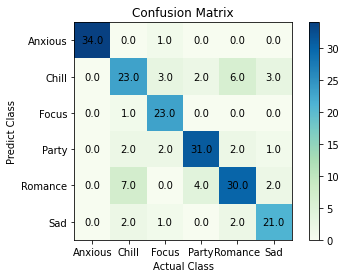

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.title("Confusion Matrix")
heatmap = ax.matshow(confusion_matrix_s,cmap='GnBu')
plt.xlabel("Actual Class")
plt.ylabel("Predict Class")
plt.colorbar(heatmap)
ax.xaxis.set_ticks_position('bottom')
ax.set_xticklabels(["",*class_labels])
ax.set_yticklabels(["",*class_labels])
for (i, j), z in np.ndenumerate(confusion_matrix_s):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
accuracy = np.trace(confusion_matrix_s)/np.sum(confusion_matrix_s)
print("Accuracy: ", accuracy)